<a href="https://colab.research.google.com/github/michaelnikhil/my_python_monitor_covid19/blob/master/my_dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID19 monitor

Python notebook to display statistics on the virus cases/deaths

Data from John Hopkins University, Center of System Science and Engineering
https://github.com/CSSEGISandData


Imports and class to load the data




In [0]:
import pandas as pd
import re
import datetime
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

class LoadData():
    def __init__(self, url):
        self.url = url

    def downloadCovid(self):
        try:
            df = pd.read_csv(self.url, sep=',', na_values=['nan'], na_filter=True)
        except:
            # dummy value
            df = pd.Series(1, index=['France'])
            print('error, using dummy data')
        return df

    def downloadPopulation(self):
        try:
            df = pd.read_csv(self.url, sep=',', na_values=['nan'], na_filter=True)
            last_col = df.columns[-1]
            country_population=pd.Series(df[last_col].values, index=df['Country'])
        except:
            country_population = pd.Series(1, index=['France'])
            print('error population, using dummy data')
        return country_population

    def retrieve_dates(self, df):
        unformatted_dates = df.columns[4:len(df.columns)]
        unformatted_dates2 = [re.sub(r"\d{2}$", r"2020", x) for x in unformatted_dates]
        dates = [datetime.datetime.strptime(x, '%m/%d/%Y') for x in unformatted_dates2]
        return dates

    def sort10(self, df):
        tmp = df.sort_values(df.columns[-1], ascending=False)
        lastDate = df.columns[-1]
        return tmp['Country/Region'][0:10], tmp[tmp.columns[-1]][0:10], lastDate

covid19_class : class Country

In [0]:
class Country():
    def __init__(self, df, country_name, dates):
        self.df = df
        self.country_name = country_name

    def nvalues(self):
        tmp = self.df[self.df['Country/Region'] == self.country_name]
        tmp = tmp.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
        val = []
        for col in tmp:
            val.append(sum(tmp[col]))
        return val

Utility functions


In [0]:
def daily_values(cumul):
    val = [0]
    for i in range(1, len(cumul)):
        val.append(cumul[i] - cumul[i - 1])
    return val

def normalise(country,val_absolute,df_population):
  for col in df_population:
    if col == country:
      if df_population[country] > 0:
        #val_relative = val_absolute / df_population[country]
        val_relative = val_absolute
      else:
        val_relative = val_absolute
  return val_relative

def format_plot(fig1, ax0):
    ax0.legend(fontsize=12, loc=0)
    ax0.xaxis.set_major_formatter(mdates.DateFormatter('%d%b'))
    ax0.yaxis.grid(True)
    fig1.autofmt_xdate()

main script to collect the data

In [0]:
# url of the data in csv file
url1 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url2 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url3 = "https://datahub.io/JohnSnowLabs/population-figures-by-country/r/population-figures-by-country-csv.csv"

# import all covid data from the url
death = LoadData(url1)
data_death = death.downloadCovid()
conf = LoadData(url2)
data_conf = conf.downloadCovid()
dates = death.retrieve_dates(data_death)

#import world population
population = LoadData(url3)
country_population = population.downloadPopulation()

# summary 10 biggest values
country_sort10, death_sort10, lastDate = death.sort10(data_death)

# choose the countries to analyse or use the 10 biggest value
# list_of_countries = ['Italy', 'Spain', 'United Kingdom', 'France', 'US', 'Sweden']
list_of_countries = country_sort10.to_list()

plots

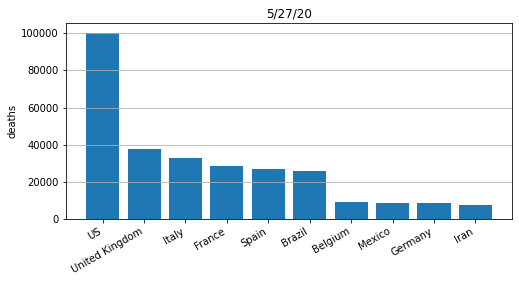

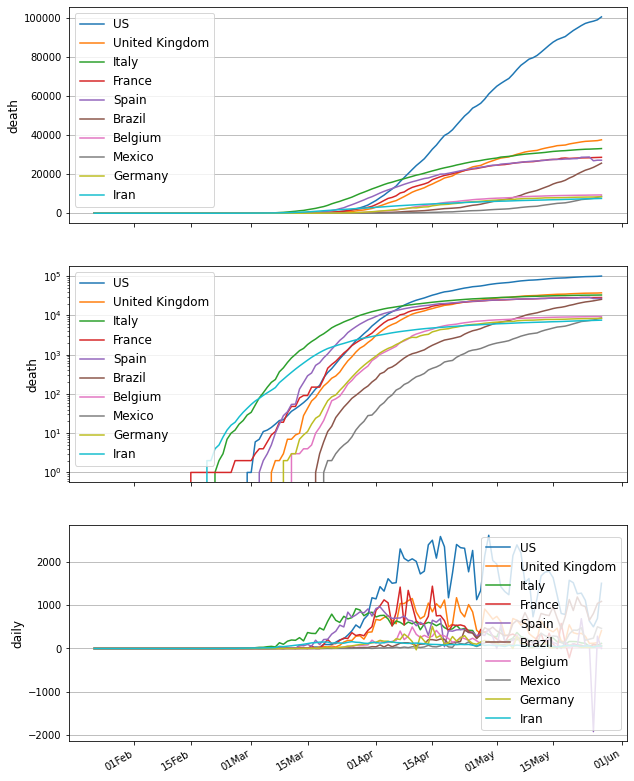

In [5]:
# plot values per country and comparing between countries
fig1, ax0 = plt.subplots(figsize=(8, 4))
pos = np.arange(10)
ax0.bar(pos, death_sort10, align='center')
ax0.set_ylabel('deaths')
plt.xticks(pos, country_sort10)
ax0.set_title(lastDate)
ax0.yaxis.grid(True)
fig1.autofmt_xdate()

fig10, (ax10, ax11, ax12) = plt.subplots(nrows=3, figsize=(10, 15))

for country in list_of_countries:
  # number of deaths
  death_country = Country(data_death, country, dates)
  n_death_country = Country(data_death, country, dates).nvalues()
  n_death_daily = daily_values(n_death_country)
  # number of confirmed cases
  conf_country = Country(data_conf, country, dates)
  n_conf_country = Country(data_conf, country, dates).nvalues()
  n_conf_daily = daily_values(n_conf_country)

  # compare countries
  ax10.plot(dates, n_death_country, label=country)
  ax10.set_ylabel('death', fontsize=12)
  format_plot(fig10, ax10)

  ax11.semilogy(dates, n_death_country, label=country)
  ax11.set_ylabel('death', fontsize=12)
  format_plot(fig10, ax11)

  ax12.plot(dates, n_death_daily, label=country)
  # ax12.plot(dates,n_conf_daily,label='confirmed cases')
  ax12.set_ylabel('daily', fontsize=12)
  format_plot(fig10, ax12)